In [2]:
import numpy as np
import h5py as h5py
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

In [3]:
system = mm.System()
mass   = 14.007 * unit.amu # masa del átomo N
system.addParticle(mass)

0

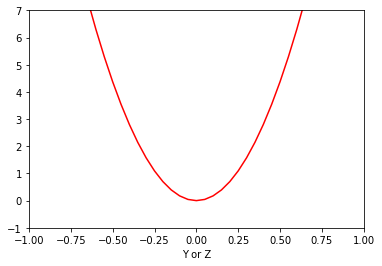

In [4]:
def harmonic_well(x,K):
    return 0.5*K*x**2

K=35.0

x_serie = np.arange(-5., 5., 0.05)
plt.rcParams['figure.figsize'] = 6,4
plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("Y or Z")
plt.show()

In [5]:
x = sy.symbols('x')
f=0.5*K*x**2
g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_yz=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_yz.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

Calculamos las raices:

Función: 17.5*x**2
Primera derivada: 35.0*x
Segunda derivada: 35.0000000000000
Minimo en coordenada 0 con k effectiva 35.0000000000000  y un periodo T de oscilación 0.1943222688752911 ps


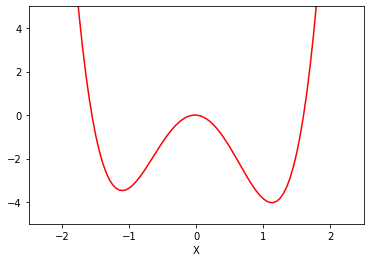

In [6]:
# 'Eo(C*x**4-x**2)+M*x'

def double_well(x,Eo,C,M):
    return Eo*(C*x**4-x**2)+M*x

Eo=6.0
C=0.4
M=-0.25 # Factor de asimetricidad.

x_serie = np.arange(-5., 5., 0.05)

plt.rcParams['figure.figsize'] = 6,4
plt.plot(x_serie, double_well(x_serie,Eo,C,M), 'r-')
plt.ylim(-5,5)
plt.xlim(-2.5,2.5)
plt.xlabel("X")
plt.show()



In [7]:
x = sy.symbols('x')
f = Eo*(C*x**4-x**2)+M*x

g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_x=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_x.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

Calculamos las raices:

Función: 2.4*x**4 - 6.0*x**2 - 0.25*x
Primera derivada: 9.6*x**3 - 12.0*x - 0.25
Segunda derivada: 28.8*x**2 - 12.0
Minimo en coordenada -1.10746801335942 con k effectiva 23.3227795376907  y un periodo T de oscilación 0.23804904374023975 ps
Minimo en coordenada 1.12830858803474 con k effectiva 24.6647117711887  y un periodo T de oscilación 0.23148271763766282 ps


In [8]:
force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)
force.addGlobalParameter('Eo', Eo * unit.kilocalories_per_mole/unit.angstrom**2)
force.addGlobalParameter('C', C * 1/unit.angstrom**2)
force.addGlobalParameter('M', M * unit.kilocalories_per_mole/unit.angstrom)
force.addParticle(0, [])
system.addForce(force)


0

In [9]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 500*unit.kelvin
pressure    = None

In [10]:
step_size       = 0.01*unit.picoseconds
num_steps       = 2000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

In [11]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [12]:
platform_name = 'CUDA'  
platform = mm.Platform.getPlatformByName(platform_name)

In [13]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

In [14]:
initial_positions  = [[roots_x[0], roots_yz[0], roots_yz[0]]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [15]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [16]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 20000/20000 [00:41<00:00, 476.96it/s]


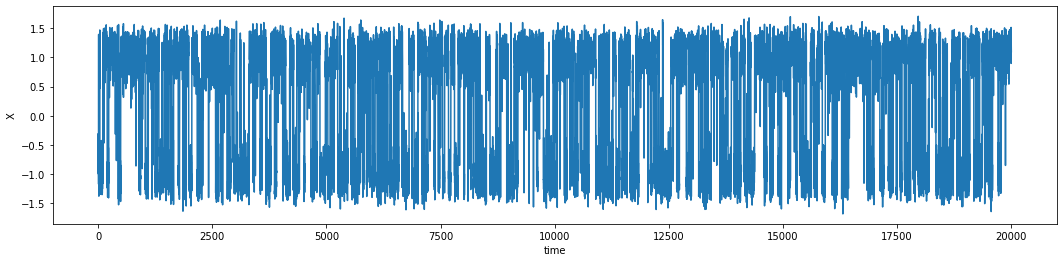

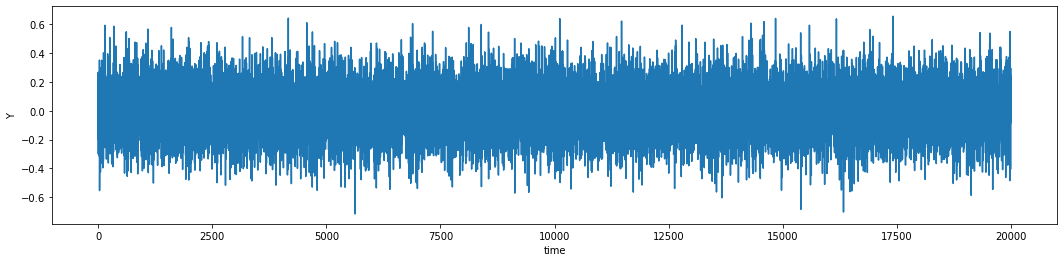

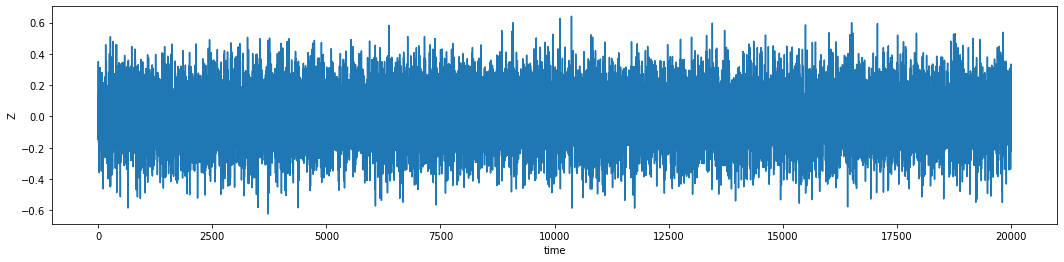

In [17]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

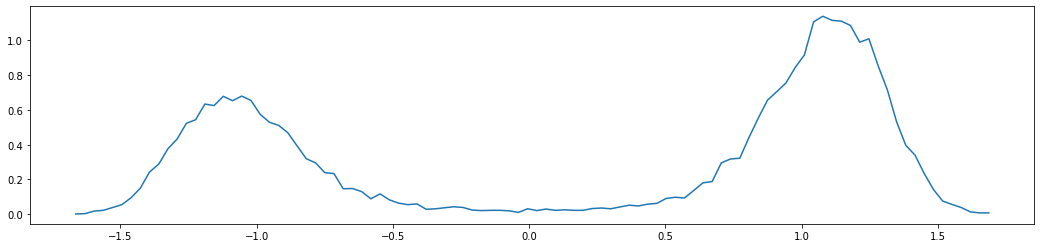

In [18]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

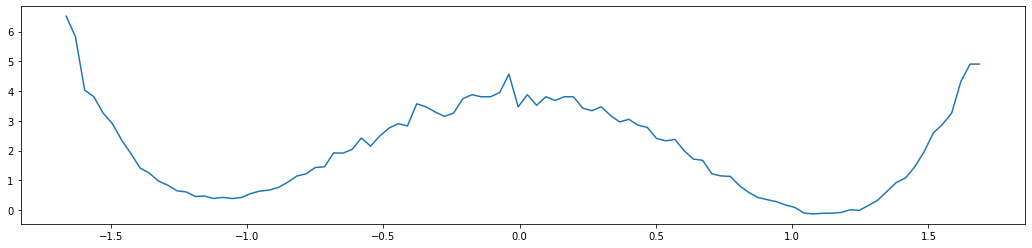

In [19]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

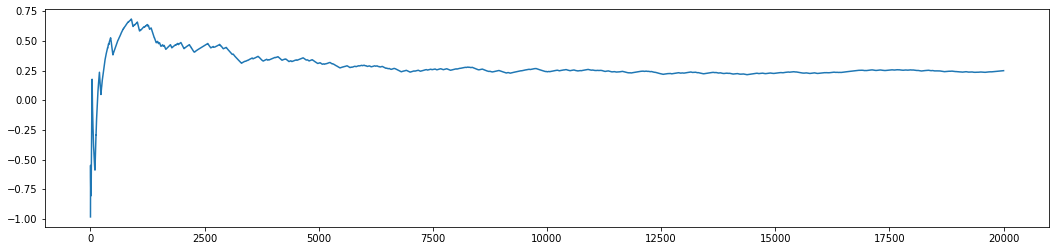

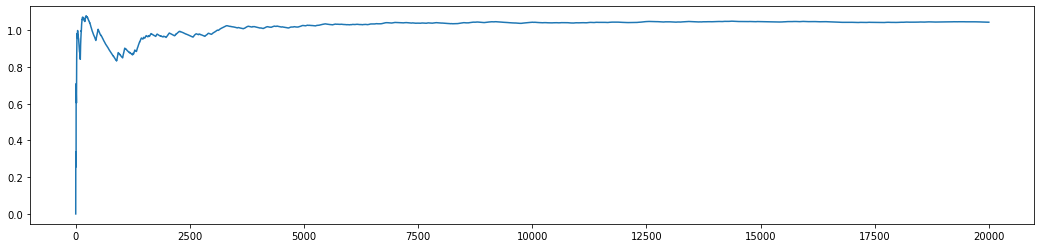

In [20]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [21]:
# ¿Qué pasa si cambiamos el valor de T?

# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 200*unit.kelvin
pressure    = None

step_size       = 0.01*unit.picoseconds
num_steps       = 2000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CUDA'  
platform = mm.Platform.getPlatformByName(platform_name)

times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

initial_positions  = [[roots_x[0], roots_yz[0], roots_yz[0]]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 20000/20000 [00:42<00:00, 469.20it/s]


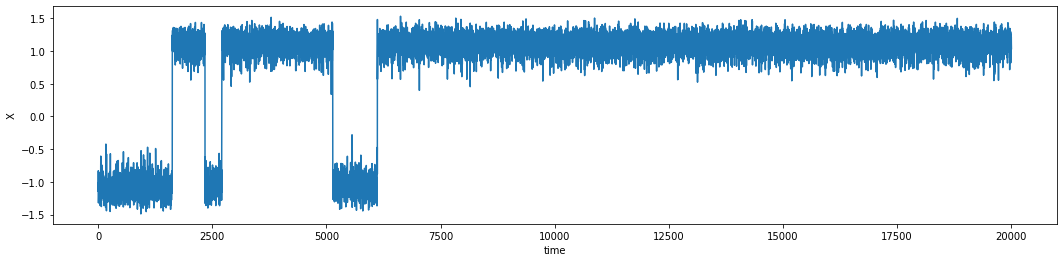

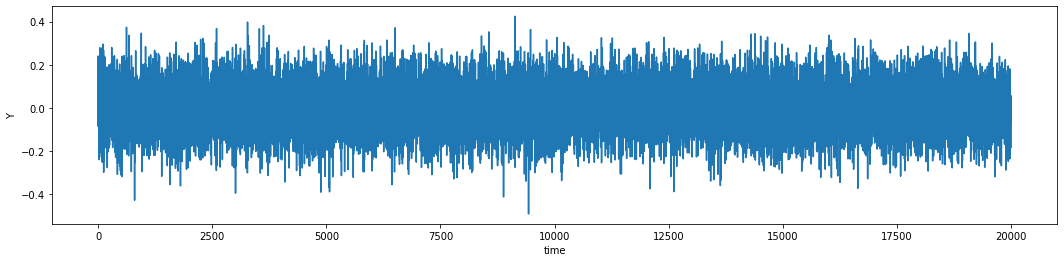

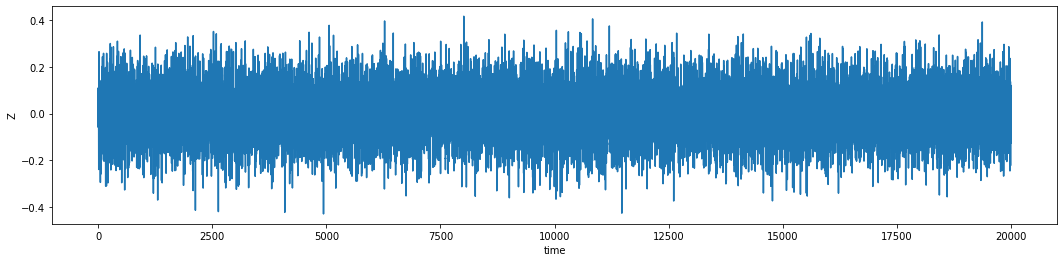

In [22]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

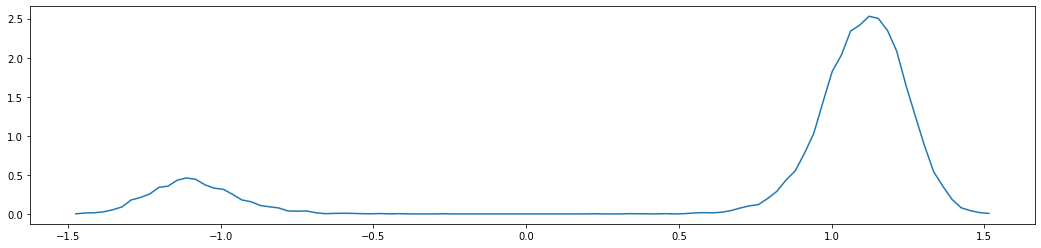

In [23]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

/home/xps/anaconda3/envs/academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


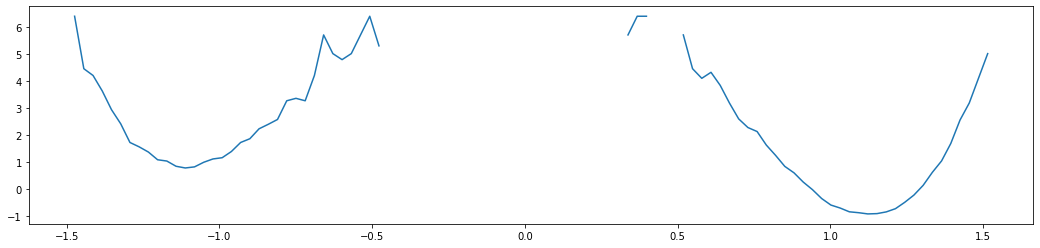

In [24]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

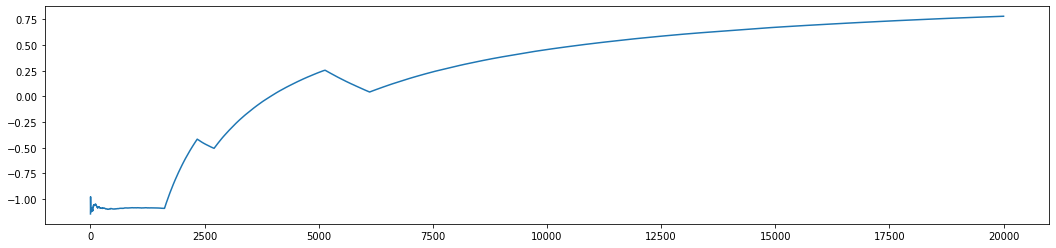

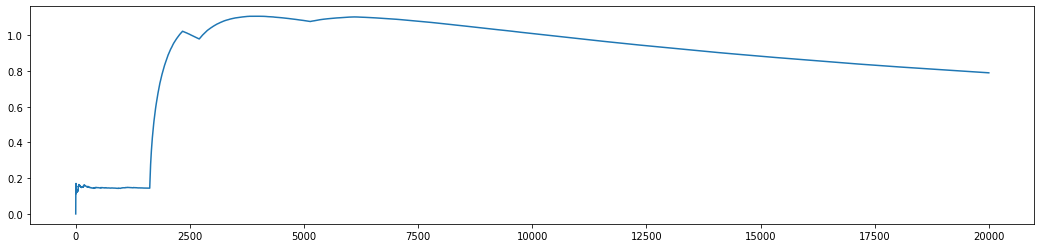

In [25]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [26]:
 # ¿Qué pasa si cambiamos el valor del timestep?

# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 500*unit.kelvin
pressure    = None

step_size       = 0.1*unit.picoseconds
num_steps       = 2000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CUDA'  
platform = mm.Platform.getPlatformByName(platform_name)

times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

initial_positions  = [[roots_x[0], roots_yz[0], roots_yz[0]]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 20000/20000 [00:39<00:00, 507.03it/s]


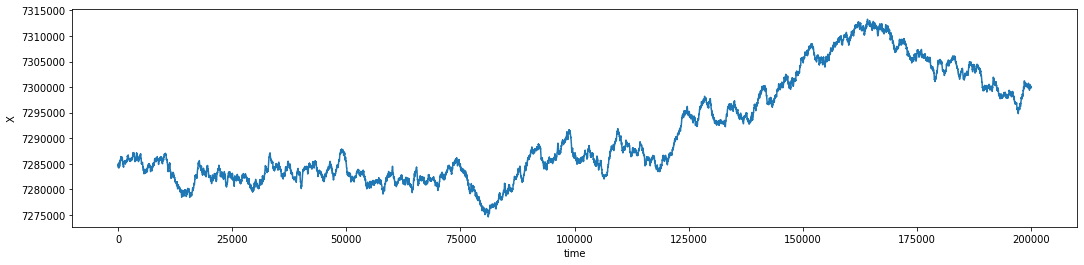

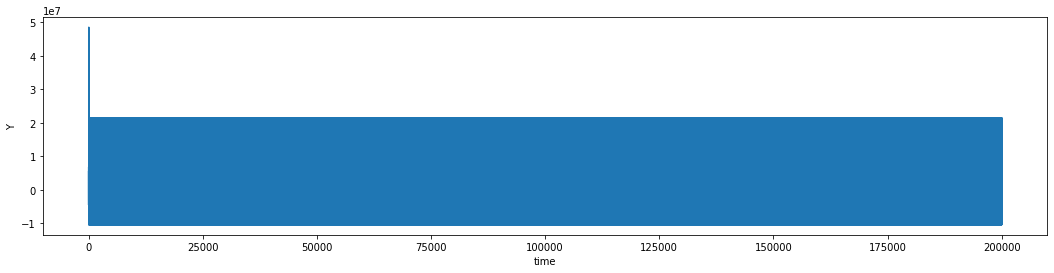

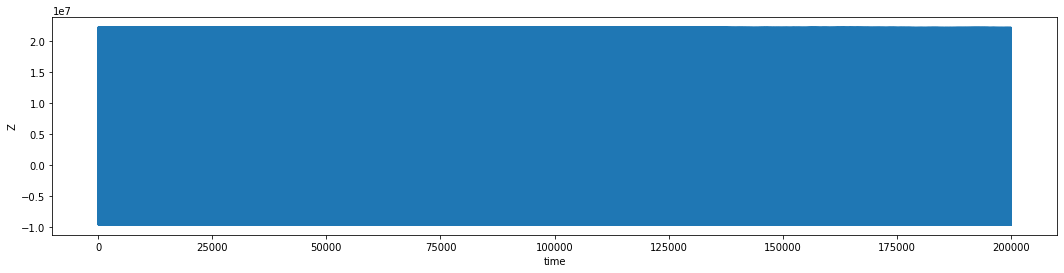

In [27]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

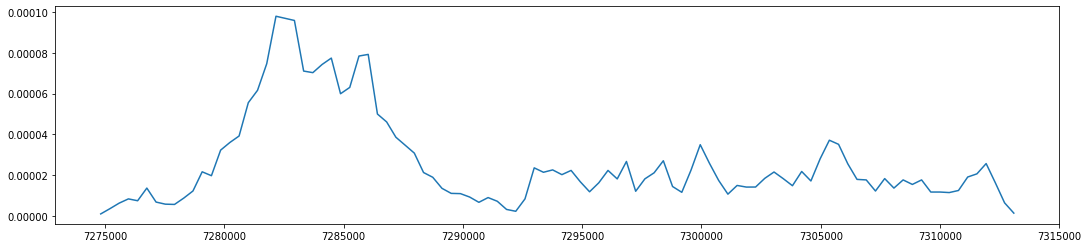

In [28]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

/home/xps/anaconda3/envs/academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


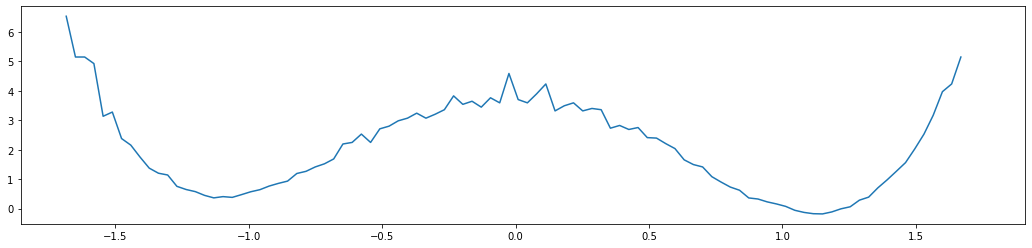

In [34]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

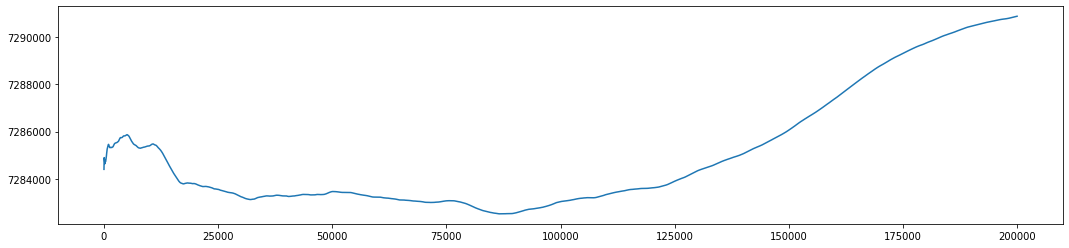

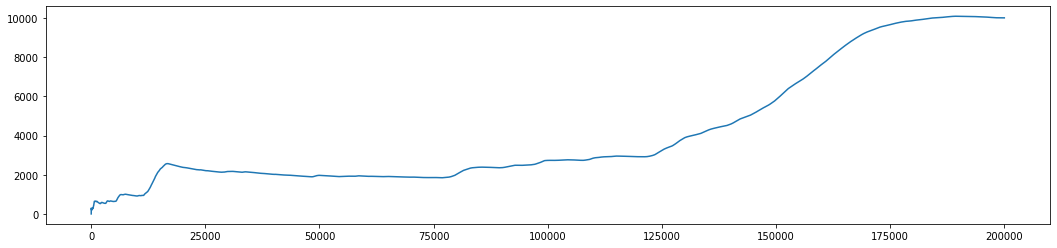

In [29]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [30]:
 # ¿Qué pasa si cambiamos el valor del damping?

# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 500*unit.kelvin
pressure    = None

step_size       = 0.01*unit.picoseconds
num_steps       = 2000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

friction   = 5.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CUDA'  
platform = mm.Platform.getPlatformByName(platform_name)

times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

initial_positions  = [[roots_x[0], roots_yz[0], roots_yz[0]]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 20000/20000 [00:42<00:00, 469.49it/s]


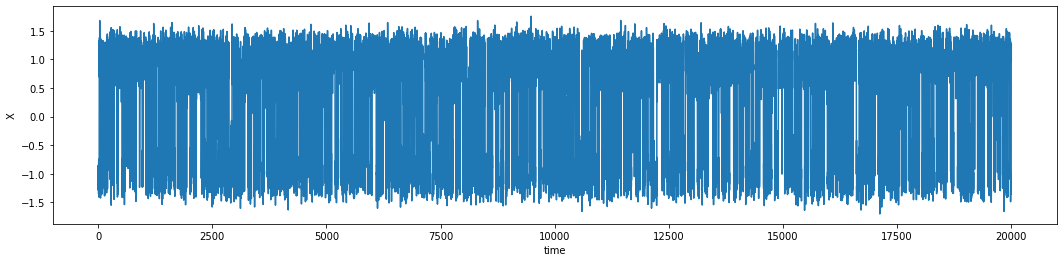

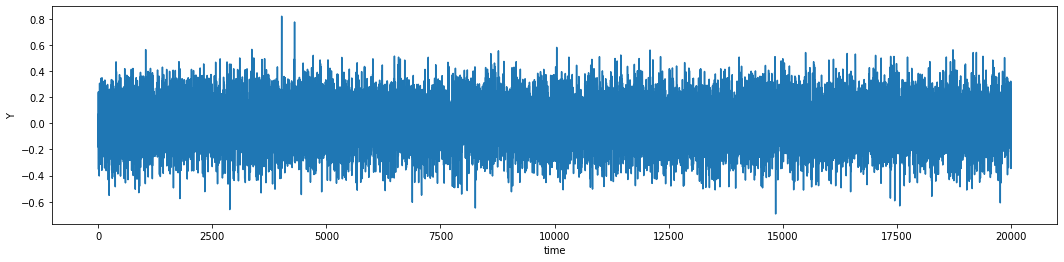

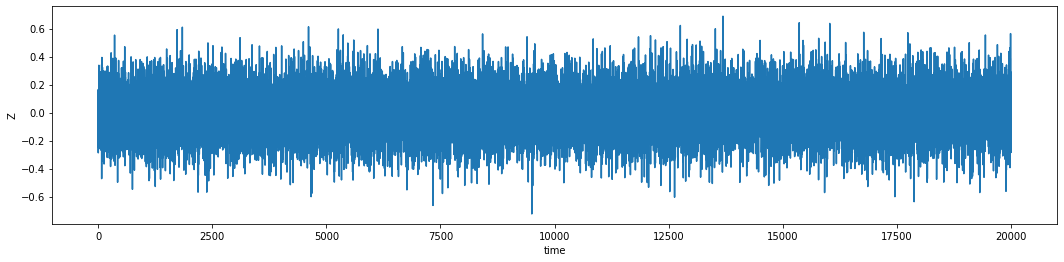

In [31]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

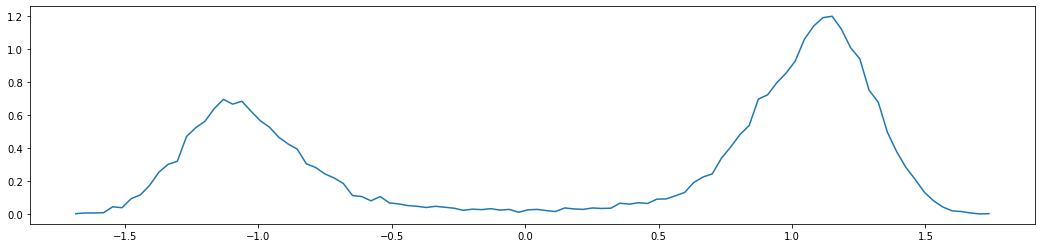

In [32]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

In [ ]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

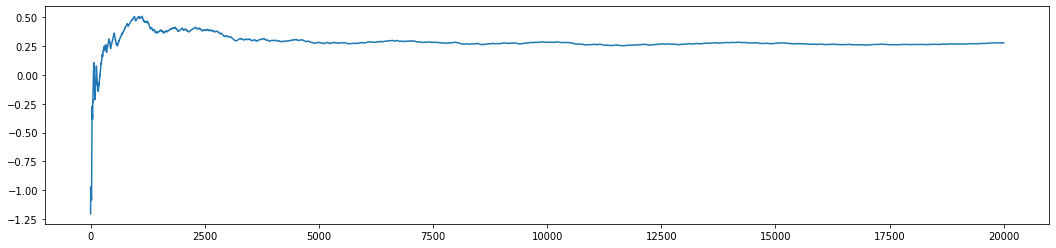

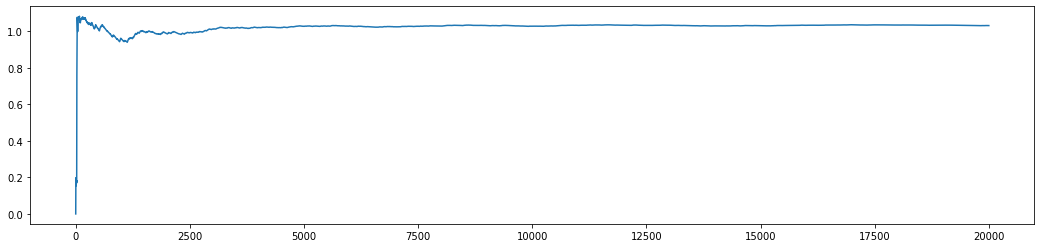

In [33]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
""""
Notar la naturaleza estocástica
¿Es más conveniente usar un valor de damping ligeramente más alto?
¿Qué pasa si la barrera del pozo es más alta?

""""